In [1]:
import numpy                         as np
import timeit
import matplotlib.pyplot             as plt
import pandas                        as  pd 
import keras


from   keras.layers                  import TimeDistributed 
from   keras.layers.convolutional    import SeparableConv1D
from   keras.layers.convolutional    import Conv1D
from   keras.layers.convolutional    import MaxPooling1D
from   keras.models                  import Sequential
from   keras.layers                  import Dropout
from   keras.layers                  import Dense
from   keras.layers                  import LSTM
from   keras.layers                  import Flatten
from   keras.layers                  import InputLayer
from   keras.regularizers            import L1L2
from   BLAS                          import *
from   tabulate                      import tabulate
from   sklearn.model_selection       import TimeSeriesSplit
from   sklearn.preprocessing         import MinMaxScaler
from   keras.callbacks               import ModelCheckpoint 

Using TensorFlow backend.


In [2]:
# Parameters
Horizon       = 4
nFeatures     = 1
nSubsequences = 1
nTimeSteps    = Horizon

# Network parameters
epochs     = 50
batch_size = 150

# other setting
chk_location = '../Final_model/weights.base.hdf5'

In [39]:
def data_retriever(coin):
    '''
    coin_raw = pd.read_csv(r'../data_binance/{}_USD_1h.csv'.format(coin),index_col=0)
    other_raw = pd.read_csv(r'../all_features_combine.csv',index_col=0)
    
    dates = coin_raw.index
    coin_raw = coin_raw.astype('float32')
    # we take the 1st Diff of our BTC open prices
    coin_raw = coin_raw['open'].diff()
    
    data = coin_raw.dropna()
    data = np.array(data)
    '''
    
    # Forming Training, Validation and Test data
    coin_data_1h_raw = pd.read_csv(r'../data_binance/{}_USD_1h.csv'.format(coin))
    coin_close_1h = coin_data_1h_raw.loc[:,'open'].diff().dropna().values
    coin_close_1h = coin_close_1h.astype('float32')
    coin_close_1h = coin_close_1h.reshape((coin_close_1h.shape[0],1))
    
    # Forming Training, Validation and Test data
    split_id = int(np.floor(coin_close_1h.shape[0] * 0.7))
    split_id_2 = int(np.floor(coin_close_1h.shape[0] * 0.8))

    TrainingData = coin_close_1h[:split_id,:]
    ValidationData = coin_close_1h[split_id:split_id_2,:]
    TestingData  = coin_close_1h[split_id_2:,:]


    #Adding last horizon values from Train data to Validation and from Validation to Test data for enabling the intial predictions on Validaiton and Test set
    ValidationData  = np.concatenate((TrainingData[-Horizon:], ValidationData), axis=0)  
    TestingData  = np.concatenate((ValidationData[-Horizon:], TestingData), axis=0)  
    
    return (TrainingData, ValidationData,TestingData) 

In [41]:
def Train_Valid_Test_split(coin, features_lvl = None, features_diff = None):
    
#     TrainingData, ValidationData,TestingData, dates = data_retriever(coin, features_lvl, features_diff)
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    #print(TrainingData.shape[0] + ValidationData.shape[0] + TestingData.shape[0], dates.shape[0] )
    #print(TrainingData[0] , ValidationData[0] , TestingData[0], dates[0] )
    
    TrainingData, ValidationData,TestingData = data_retriever('BTC')
    
    
    # Always put the target variable to the last column (at the right)
    target_var = nFeatures-1

    trainX, trainY = create_dataset(TrainingData, Horizon, target_var)
    validX, validY = create_dataset(ValidationData, Horizon, target_var)
    testX, testY = create_dataset(TestingData, Horizon, target_var)
    
    # In order to match Prakarsh's outputs of this function we will independantly compute trainY_raw, validY_raw, testY_raw 
    # which are simply the first difference of the BTC price (without being flagged by -1 or 1) 
    
        ## Reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
    ## =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    trainX = np.reshape(trainX, (trainX.shape[0], nSubsequences, Horizon, nFeatures))
    validX = np.reshape(validX, (validX.shape[0], nSubsequences, Horizon, nFeatures))
    testX  = np.reshape(testX,  (testX.shape[0],  nSubsequences, Horizon, nFeatures))
    
    trainY_raw = trainY
    validY_raw = validY
    testY_raw = testY
    
    
    ## To remplace 0 values: 2 options:
    
#     1.
    trainY = np.sign(trainY)
    trainY[trainY==0] = -1
    validY =np.sign(validY)
    validY[validY==0] = -1
    testY =np.sign(testY)
    testY[testY==0] = -1
    
#     2.
#     trainY[trainY[:] == 0] = np.sign(np.mean(trainY))
#     validY[validY[:] == 0] = np.sign(np.mean(validY))
#     testY[testY[:] == 0] = np.sign(np.mean(testY))
    
    
    #print(trainX[0],trainY_raw[0])
    #print(validX[0],  validY_raw[0])
    #print(testX[0],testY_raw[0])
    return (trainX,trainY,validX,validY,testX,testY, trainY_raw, validY_raw, testY_raw) 

In [26]:
def model_CNN_LSTM():
    model = Sequential()
    
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=2, padding='valid', activation='relu'), 
                              input_shape=(None, nTimeSteps, nFeatures))) 
    model.add(TimeDistributed(Dropout(0.05)))

    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu'), 
                              input_shape=(None, nTimeSteps, nFeatures)) )
    model.add(TimeDistributed(Dropout(0.05)))     
    
    model.add(TimeDistributed(Flatten()))
   
    model.add(LSTM(50, activation='relu', dropout = 0.2, kernel_regularizer = L1L2(l1=0.01, l2=0.01)))
    model.add(Dense(1, activation = 'tanh'))  #Final activation tanh function
    
    print("\nModel Architecture \n")
    model.summary()
    model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])
    
    return model

def model_CNN():
    model2 = Sequential()
    
    model2.add(Conv1D(filters=32, kernel_size=2, padding='valid', activation='relu',input_shape=(nTimeSteps, nFeatures)))
    model2.add(Dropout(0.05))

    model2.add(Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu'))

    model2.add(Dropout(0.05))    
    model2.add(Flatten())
    
    model2.add(Dense(1, activation = 'tanh'))  #Final activation tanh function
    
    model2.summary()
    model2.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])
    print("\nModel Architecture \n")
   
    
    return model2

def model_LSTM():
    model3 = Sequential()
  
    model3.add(LSTM(50, activation='relu', dropout = 0.2, kernel_regularizer = L1L2(l1=0.01, l2=0.01)))
    model3.add(Dense(1, activation = 'tanh'))  #Final activation tanh function
    
    print("\nModel Architecture \n")
    model3.compile(loss='mean_absolute_error', optimizer='adam', metrics = ['accuracy'])
    #model3.summary()
    
    return model3

In [38]:
def model_constructor(coin, model_type = None):
    
    trainX,trainY,validX,validY,testX,testY, trainY_raw, validY_raw, testY_raw = Train_Valid_Test_split(coin)
   
    if model_type == 'CNN':
        model = model_CNN()
        trainX = trainX.reshape(trainX.shape[0], nTimeSteps, nFeatures)
        validX = validX.reshape(validX.shape[0], nTimeSteps, nFeatures)
        testX = testX.reshape(testX.shape[0], nTimeSteps, nFeatures)
        
        
    elif model_type == 'LSTM':
        model = model_LSTM()
        trainX = trainX.reshape(trainX.shape[0], nTimeSteps, nFeatures)
        validX = validX.reshape(validX.shape[0], nTimeSteps, nFeatures)
        testX = testX.reshape(testX.shape[0], nTimeSteps, nFeatures)
        
    elif model_type == 'CNN_LSTM':
        model = model_CNN_LSTM()
        
    
    
    #print(trainX.shape)
    
    return model, trainX,trainY,validX,validY,testX,testY


In [37]:
def model_trainer(coin, model_type):
    model,trainX,trainY,validX,validY,testX,testY= model_constructor(coin, model_type)
    
    checkpointer = ModelCheckpoint(filepath         = chk_location, 
                               monitor          = "val_accuracy", 
                               verbose          =  0, 
                               save_best_only   = True)
    
    print("\nModel Training \n")
    #print(trainX.shape)
    score = model.fit(trainX, trainY,
                  validation_data = (validX, validY),
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpointer],
                  verbose         = 0)
    model.summary()
    
    plt.plot(score.history['loss'])
    plt.plot(score.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    model.load_weights(chk_location)
    testPredict = np.sign(model.predict(testX))
    
    return testPredict, model, testY

In [33]:
def results_plotter(coin, model_type):
    testPredict, model, testY = model_trainer(coin, model_type)
    
    fig, axs = plt.subplots(1)
    fig.suptitle('\nWeights Distribution for {} Price movement Prediction'.format(coin))
    n, bins, patches = axs.hist(testPredict, 10, density=True, facecolor='b', alpha=0.5)
    axs.set_ylabel('Predicted Sign')
    axs.set_xlabel('Direction')

    axes = plt.gca()
    
    plt.grid(True, alpha=0.5)
    plt.rcParams["figure.figsize"] = (10,7)
    plt.show()
    
    #Results Analysis
    print("\n Results Analysis \n")
    CM, Accuracy, F1, AUC,tpr, fpr = ClassificationEvaluation(testY, testPredict, True)
    print(tabulate(pd.DataFrame([Accuracy,AUC,F1], index = ['Accuracy', 'F1 Score', 'Area Under ROC']), headers = ['Metric', 'Values'], tablefmt = 'psql'))
          
    # Check confusion matrix (by Livieris)
    print('\n Confusion matrix')
    print(tabulate(pd.DataFrame(CM, index =['True Positive', 'True Negative']),headers= ['Pred. Positive','Pred Negative'],tablefmt='psql'))

    print('\n')
    

In [34]:
def ClassificationEvaluation(testY, Pred, plots = False):
    
    N        = testY.shape[0]
   
    CM       = metrics.confusion_matrix(testY, Pred)
    Accuracy = metrics.accuracy_score(testY, Pred)
    F1       = metrics.f1_score(testY, Pred)
    
    fpr, tpr, thresholds = metrics.roc_curve(testY, Pred, drop_intermediate = False)
    
    #Area under ROC curve
    AUC = metrics.auc(fpr, tpr)
    if (plots):
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                     label='ROC (AUC = %0.4f)' % AUC)
        plt.legend(loc='lower right')
        plt.title("ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
 
    
    return (CM, Accuracy, F1, AUC, tpr, fpr)

In [48]:
def rolling_horizon(coin, model_type, plots):
    result = pd.DataFrame(columns = ['Accuracy', 'F1 score'])
    for i in range(1, 10):
        Horizon = i
        nTimeSteps = i
        print(Horizon)
        testPredict, model, testY = model_trainer(coin, model_type)
        CM, Accuracy, F1, AUC,tpr, fpr = ClassificationEvaluation(testY, testPredict, plots)
        result.loc[i] = [Accuracy, F1]
    return result

1
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_45 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_46 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

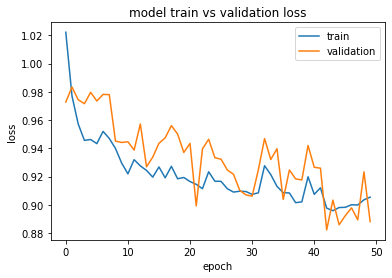

2
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_47 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_47 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_48 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

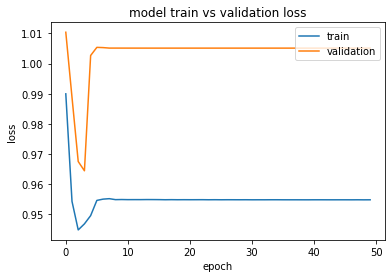

3
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_49 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_50 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

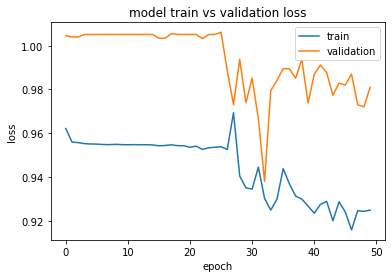

4
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_51 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_52 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

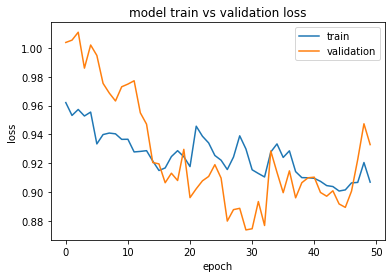

5
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_53 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_53 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_54 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

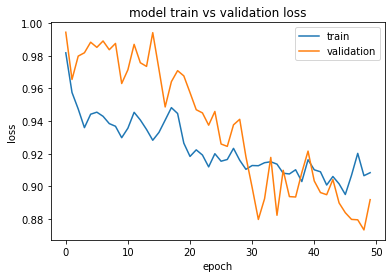

6
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_55 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_55 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_56 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

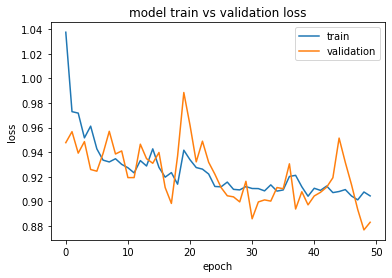

7
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_57 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_58 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

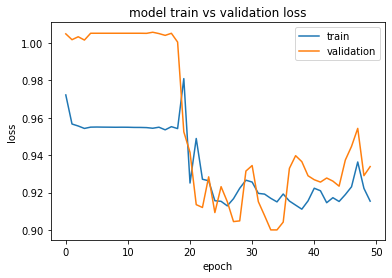

8
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_59 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_59 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_60 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

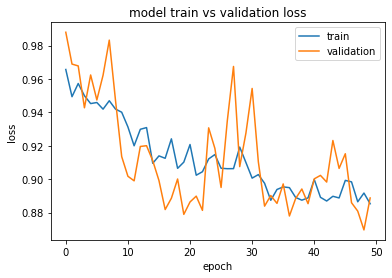

9
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 8, 32)             96        
_________________________________________________________________
dropout_61 (Dropout)         (None, 8, 32)             0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 7, 64)             4160      
_________________________________________________________________
dropout_62 (Dropout)         (None, 7, 64)             0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 448)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 449       
Total params: 4,705
Trainable params: 4,705
Non-trainable params: 0
_________________________________________________

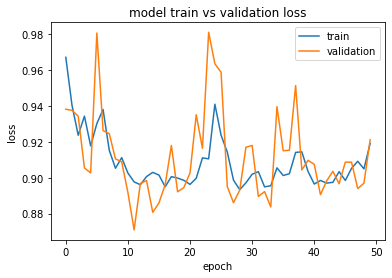

ValueError: axes don't match array

In [49]:
result_cnn = rolling_horizon('BTC', 'CNN', False)
result_cnn.plot()

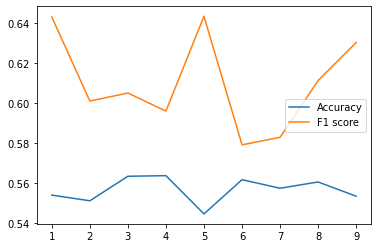

In [51]:
result_cnn.plot()

1

Model Architecture 

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_56 (TimeDis (None, None, 8, 32)       96        
_________________________________________________________________
time_distributed_57 (TimeDis (None, None, 8, 32)       0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, None, 7, 64)       4160      
_________________________________________________________________
time_distributed_59 (TimeDis (None, None, 7, 64)       0         
_________________________________________________________________
time_distributed_60 (TimeDis (None, None, 448)         0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 50)                99800     
_________________________________________________________________
dense_53 (Dense)             

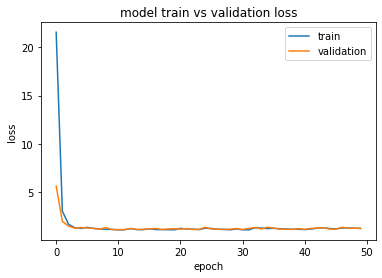

ValueError: You are trying to load a weight file containing 6 layers into a model with 4 layers.

In [52]:
result_cnn_lstm = rolling_horizon('BTC', 'CNN_LSTM', False)
result_cnn_lstm.plot()

### Rolling window size selection
1. Check the rolling and which size has the best performance

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_27 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_28 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

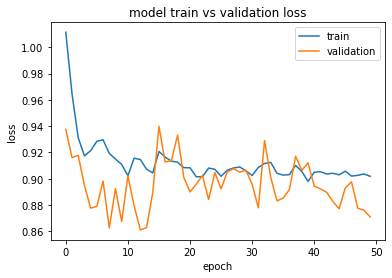

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_29 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

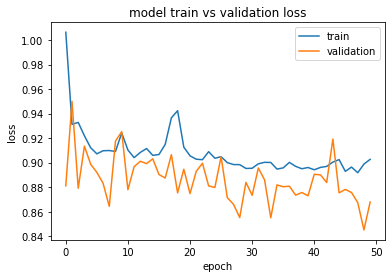

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_31 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_32 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

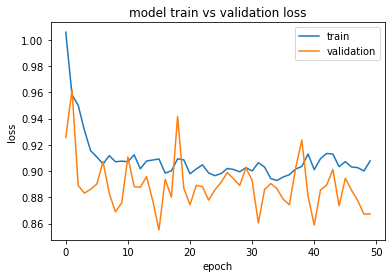

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_33 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_34 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

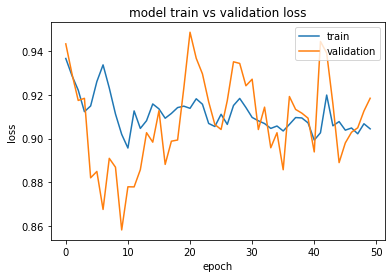

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_35 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_36 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

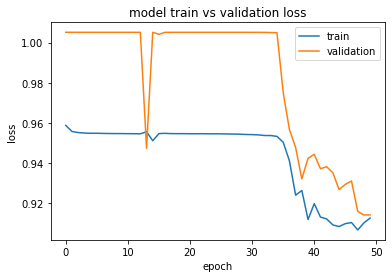

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_37 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

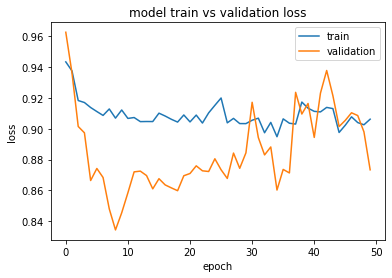

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_39 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_40 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

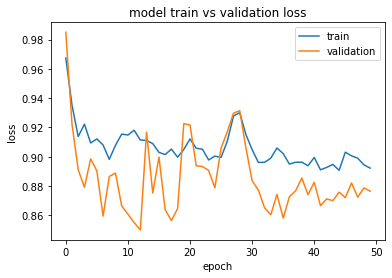

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_41 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_42 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

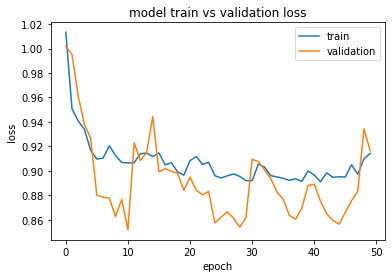

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 3, 32)             96        
_________________________________________________________________
dropout_43 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 2, 64)             4160      
_________________________________________________________________
dropout_44 (Dropout)         (None, 2, 64)             0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
___________________________________________________

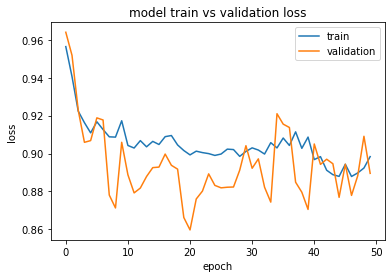

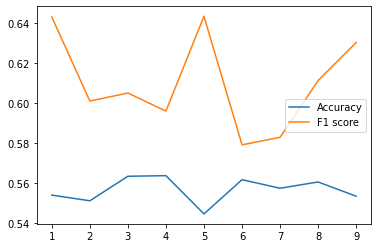

In [42]:
result_cnn = rolling_horizon('BTC', 'CNN', False)
result_cnn.plot()


Model Architecture 


Model Training 

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


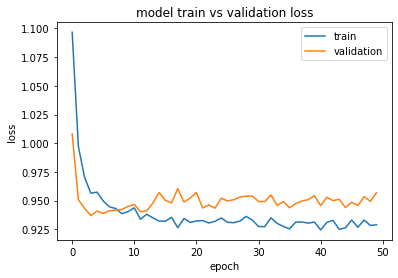


Model Architecture 


Model Training 

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


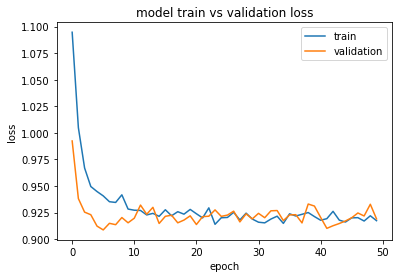


Model Architecture 


Model Training 

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


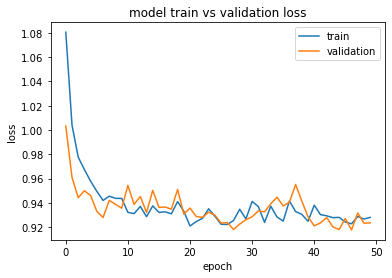


Model Architecture 


Model Training 

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


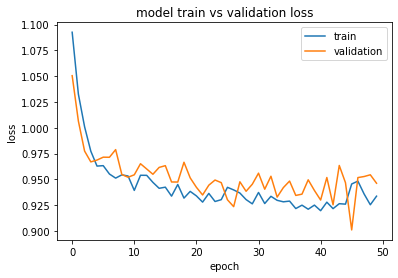


Model Architecture 


Model Training 

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


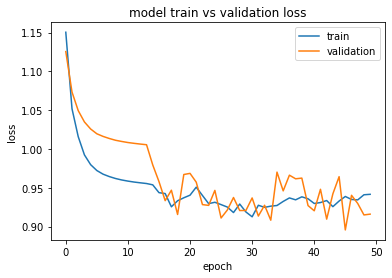


Model Architecture 


Model Training 

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


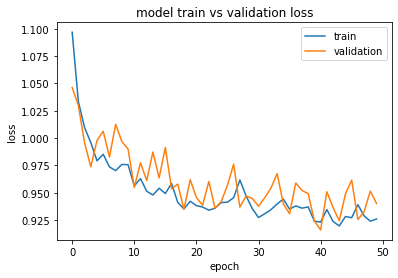


Model Architecture 


Model Training 

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


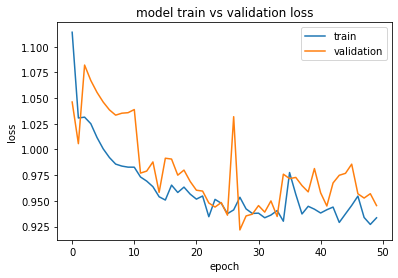


Model Architecture 


Model Training 

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


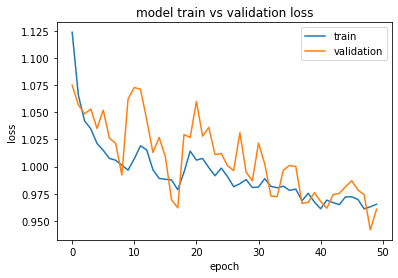


Model Architecture 


Model Training 

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


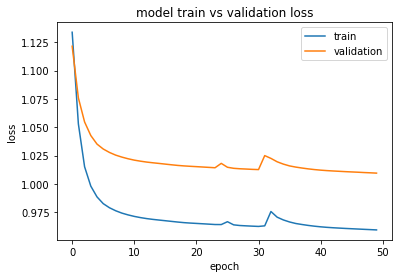

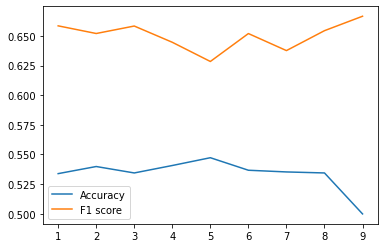

In [47]:
#result_lstm = rolling_horizon('BTC', 'LSTM', False)
result_lstm = pd.DataFrame(columns = ['Accuracy', 'F1 score'])
for i in range(1, 10):
    Horizon = i
    nTimeSteps = i
    testPredict, model, testY = model_trainer('BTC', 'LSTM')
    CM, Accuracy, F1, AUC,tpr, fpr = ClassificationEvaluation(testY, testPredict, False)
    result_lstm.loc[i] = [Accuracy, F1]
result_lstm.plot()

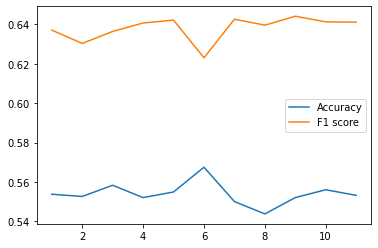

In [16]:
#result_lstm_cnn = rolling_horizon('BTC', 'CNN_LSTM', False)
result_lstm_cnn.plot()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 3, 32)             96        
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 64)             4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
____________________________________________________

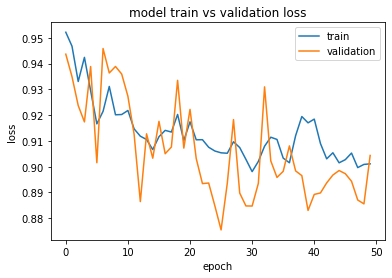

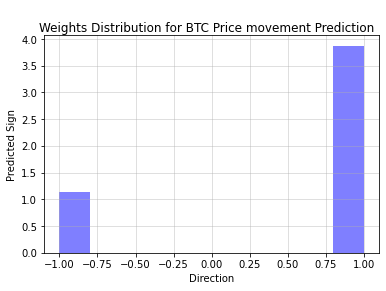


 Results Analysis 



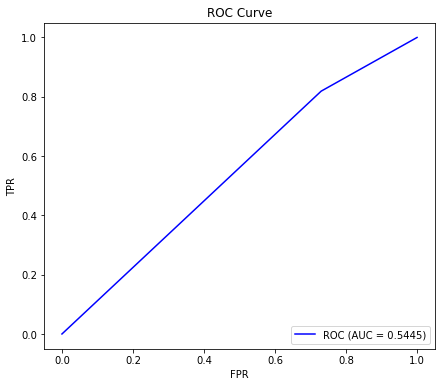

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.544391 |
| F1 Score       | 0.544469 |
| Area Under ROC | 0.642473 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Positive |   Pred Negative |
|---------------+------------------+-----------------|
| True Positive |              473 |            1279 |
| True Negative |              317 |            1434 |
+---------------+------------------+-----------------+




In [51]:
results_plotter('BTC','CNN')


Model Architecture 


Model Training 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


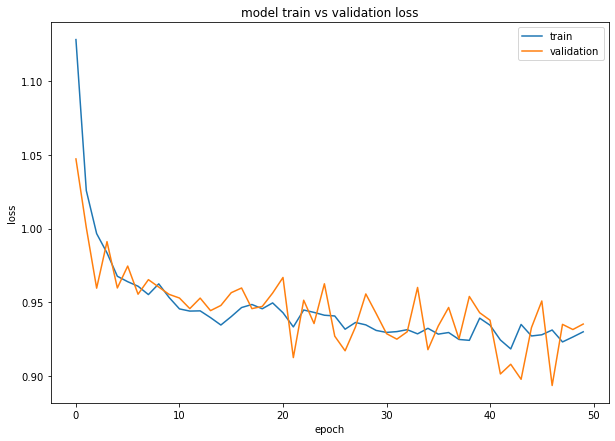

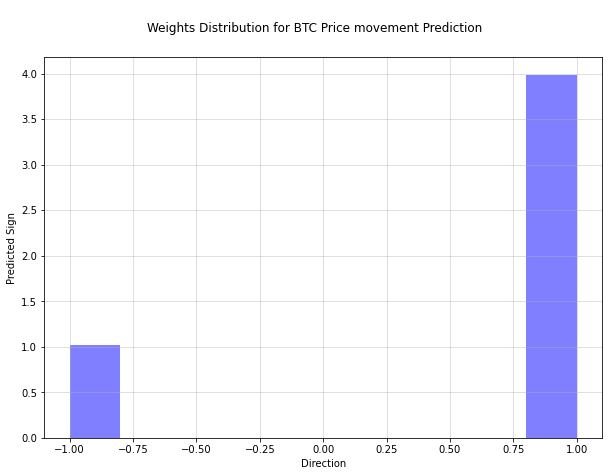


 Results Analysis 



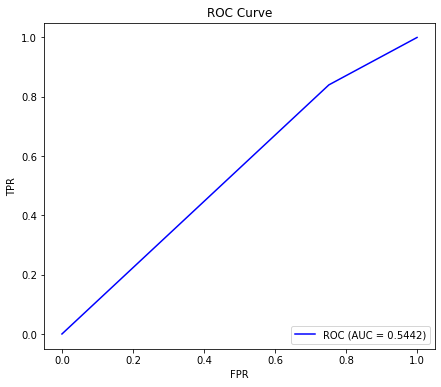

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.544105 |
| F1 Score       | 0.54419  |
| Area Under ROC | 0.64816  |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Positive |   Pred Negative |
|---------------+------------------+-----------------|
| True Positive |              435 |            1317 |
| True Negative |              280 |            1471 |
+---------------+------------------+-----------------+




In [52]:
results_plotter('BTC','LSTM')


Model Architecture 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 3, 32)       96        
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 3, 32)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 2, 64)       4160      
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 2, 64)       0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                35800     
_________________________________________________________________
dense_5 (Dense)              (No

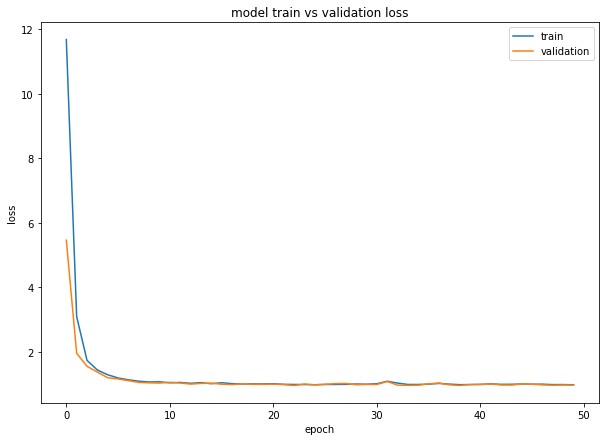

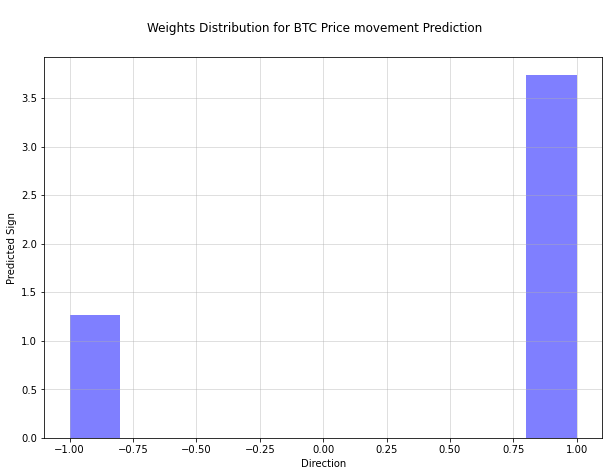


 Results Analysis 



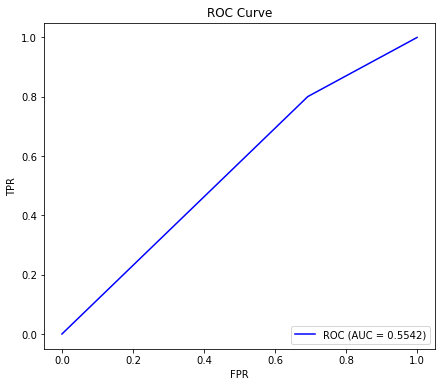

+----------------+----------+
| Metric         |   Values |
|----------------+----------|
| Accuracy       | 0.554096 |
| F1 Score       | 0.554167 |
| Area Under ROC | 0.642235 |
+----------------+----------+

 Confusion matrix
+---------------+------------------+-----------------+
|               |   Pred. Positive |   Pred Negative |
|---------------+------------------+-----------------|
| True Positive |              539 |            1213 |
| True Negative |              349 |            1402 |
+---------------+------------------+-----------------+




In [53]:
results_plotter('BTC','CNN_LSTM')